In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


In [3]:
img_size = (48, 48)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # split train into train+val
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Path to your dataset
train_path = "/kaggle/input/fer2013plus/fer2013plus/fer2013/train"
test_path = "/kaggle/input/fer2013plus/fer2013plus/fer2013/test"

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    subset='validation',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=1,
    shuffle=False
)


Found 22712 images belonging to 8 classes.
Found 5674 images belonging to 8 classes.
Found 7099 images belonging to 8 classes.


In [5]:
input_shape = (48, 48, 3)

base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
base_model.trainable = False  # Freeze base model

inputs = Input(shape=input_shape)
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/tmp/ipykernel_35/2935572828.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 2, 2, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,984 (9.24 MB)

 Trainable params: 165,000 (644.53 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [7]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1),
    ModelCheckpoint("best_model_mobilenet.keras", monitor='val_accuracy', save_best_only=True, verbose=1)
]

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks
)


Epoch 1/20
710/710 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.3332 - loss: 1.8228
Epoch 1: val_accuracy improved from -inf to 0.42721, saving model to best_model_mobilenet.keras
710/710 ━━━━━━━━━━━━━━━━━━━━ 98s 138ms/step - accuracy: 0.3332 - loss: 1.8227 - val_accuracy: 0.4272 - val_loss: 1.5014 - learning_rate: 1.0000e-04
Epoch 2/20
709/710 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4013 - loss: 1.5661
Epoch 2: val_accuracy improved from 0.42721 to 0.45083, saving model to best_model_mobilenet.keras
710/710 ━━━━━━━━━━━━━━━━━━━━ 31s 43ms/step - accuracy: 0.4013 - loss: 1.5660 - val_accuracy: 0.4508 - val_loss: 1.4521 - learning_rate: 1.0000e-04
Epoch 3/20
709/710 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4249 - loss: 1.4838
Epoch 3: val_accuracy improved from 0.45083 to 0.46211, saving model to best_model_mobilenet.keras
710/710 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - accuracy: 0.4249 - loss: 1.4838 - val_accuracy: 0.4621 - val_loss: 1.4276 - learning_rate: 1.0000e-04
Ep

In [8]:
# Validation accuracy
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

# Test accuracy
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


178/178 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.4281 - loss: 1.5178
Validation Accuracy: 51.53%
7099/7099 ━━━━━━━━━━━━━━━━━━━━ 66s 9ms/step - accuracy: 0.4149 - loss: 1.5591
Test Accuracy: 50.66%


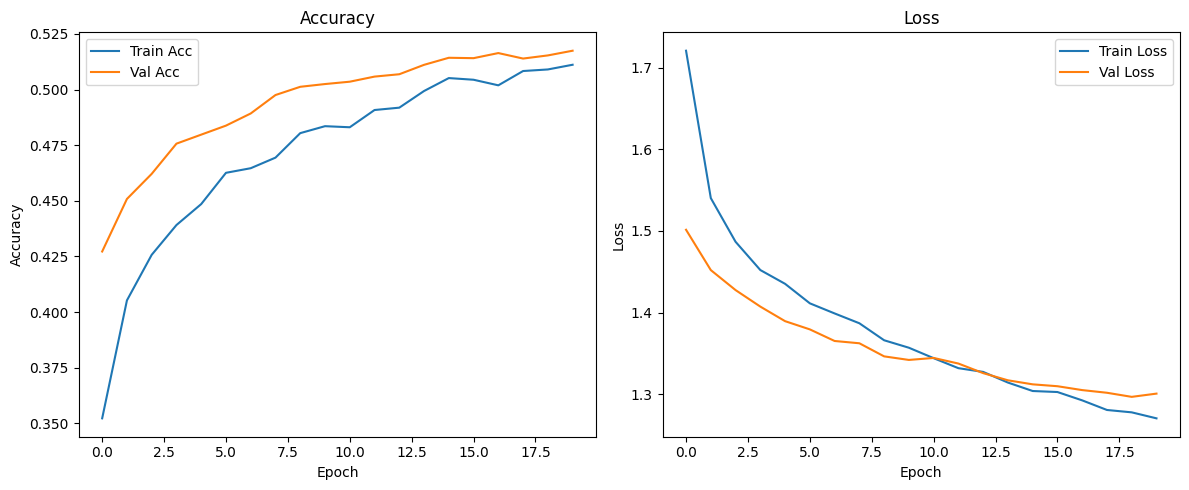

In [9]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def predict_emotion(image_path):
    # Check if the file exists
    if not os.path.exists(image_path):
        print(f"❌ File does not exist: {image_path}")
        return

    # Load the image
    img = cv2.imread(image_path)

    # Check if image is loaded properly
    if img is None:
        print(f"❌ Failed to load image from: {image_path}")
        return

    # Convert BGR to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize to 48x48
    img_resized = cv2.resize(img_rgb, (48, 48))

    # Normalize and add batch dimension
    img_array = img_resized / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Shape: (1, 48, 48, 3)

    # Predict
    prediction = model.predict(img_array)

    # Get class labels from the train generator
    class_labels = list(train_generator.class_indices.keys())
    predicted_emotion = class_labels[np.argmax(prediction)]

    # Output
    print(f"✅ Predicted Emotion: {predicted_emotion}")

    # Plot image with prediction
    plt.imshow(img_resized)
    plt.title(f"Predicted: {predicted_emotion}")
    plt.axis('off')
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
✅ Predicted Emotion: happiness


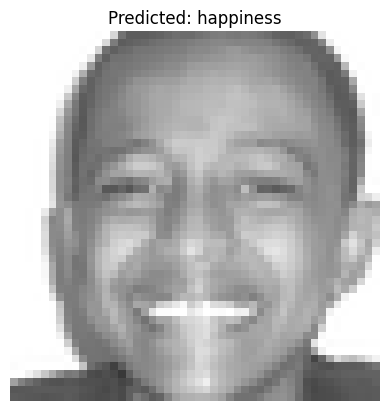

In [18]:
predict_emotion('/kaggle/input/fer2013plus/fer2013plus/fer2013/test/happiness/fer0028725.png')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
✅ Predicted Emotion: neutral


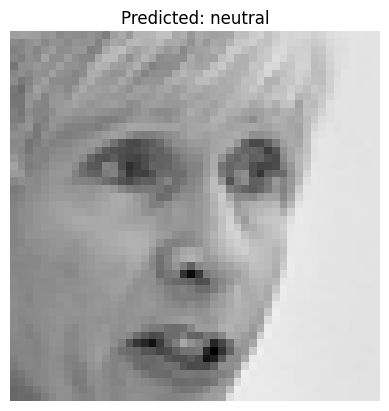

In [19]:
predict_emotion('/kaggle/input/fer2013plus/fer2013plus/fer2013/test/neutral/fer0028655.png')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
✅ Predicted Emotion: happiness


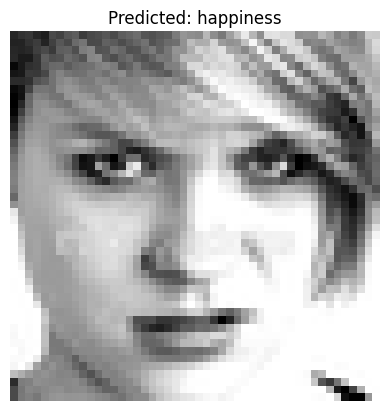

In [20]:

predict_emotion('/kaggle/input/fer2013plus/fer2013plus/fer2013/test/contempt/fer0030620.png')



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
✅ Predicted Emotion: neutral


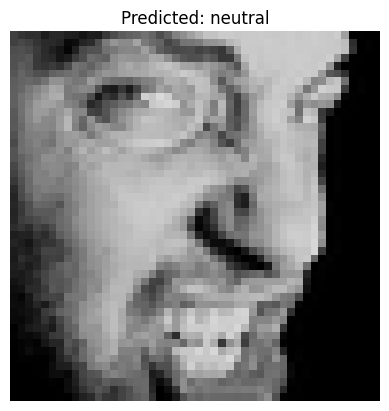

In [21]:

predict_emotion('/kaggle/input/fer2013plus/fer2013plus/fer2013/test/anger/fer0028749.png')



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
✅ Predicted Emotion: neutral


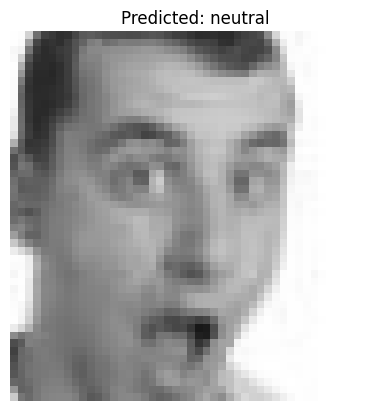

In [22]:

predict_emotion('/kaggle/input/fer2013plus/fer2013plus/fer2013/test/surprise/fer0028690.png')



In [23]:
# Save the entire model
model.save("emotion_model_mobilenet_v1.h5")  # or .keras


In [ ]:
# Re-evaluate to confirm model works after loading
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy After Loading: {acc * 100:.2f}%")
